# Import

In [1]:
#@title Import { display-mode: "form" }
import numpy as np
import datetime
import tensorflow.compat.v2 as tf
import tensorboard
import os
tf.enable_v2_behavior()

#import tensorflow_datasets as tfds
import tensorflow_probability as tfp
np.random.seed(43)
tf.random.set_seed(43) 

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

import matplotlib.pyplot as plt
import sys

ModuleNotFoundError: No module named 'tensorflow_probability'

In [4]:
#!pip install tensorflow_probability

In [2]:
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.11.0
TF  Version 2.3.0


In [3]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))
  !nvidia-smi

## Network

In [4]:
def create_model():
    seq = tfk.models.Sequential()
    seq.add(tfkl.ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       input_shape=(None, 34, 34, 1),
                       padding='same', return_sequences=True))
    seq.add(tfkl.BatchNormalization())

    seq.add(tfkl.ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    seq.add(tfkl.BatchNormalization())

    seq.add(tfkl.ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    seq.add(tfkl.BatchNormalization())

    seq.add(tfkl.ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    seq.add(tfkl.BatchNormalization())

    seq.add(tfkl.Conv3D(filters=1, kernel_size=(3, 3, 3),
                   activation='sigmoid',
                   padding='same', data_format='channels_last'))
    
    opt = tfk.optimizers.Adadelta(learning_rate=0.001)
    loss_fn =  tfk.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM)
    seq.compile(loss=loss_fn, optimizer=opt)
    
    return seq

# Data Prep

In [5]:
def create_patch_data(data,patch_size):
    input_shape    = list(data.shape)
    Number_of_frames,timestep,W,H,Channels = input_shape
    assert W==H
    num_patches  = int(np.ceil(W/patch_size))
    pad = patch_size*num_patches - W 
    New_Number_of_frames = Number_of_frames*(num_patches**2)
    New_W = patch_size
    New_H = patch_size
    Patch_data = np.zeros((New_Number_of_frames,timestep,New_W,New_H,Channels))
    for i in range(num_patches):
        for j in range(num_patches):
            if(i==num_patches-1 and j==num_patches-1):
                #print((i*34,((i+1)*34-pad)),(j*34,(j+1)*34-pad),1.1)
                Patch_data[Number_of_frames*(j+num_patches*i):Number_of_frames*((j+num_patches*i)+1),:,:-pad,:-pad,:] = data[:,:,i*patch_size:(i+1)*patch_size-pad,j*patch_size:(j+1)*patch_size-pad,:]
            elif(i==num_patches-1):
                #print((i*34,((i+1)*34-pad)),(j*34,(j+1)*34),1.0)
                Patch_data[Number_of_frames*(j+num_patches*i):Number_of_frames*((j+num_patches*i)+1),:,:-pad,:,:] = data[:,:,i*patch_size:(i+1)*patch_size-pad,j*patch_size:(j+1)*patch_size,:]
            elif(j==num_patches-1):
                #print((i*34,((i+1)*34)),(j*34,(j+1)*34-pad),0.1)
                Patch_data[Number_of_frames*(j+num_patches*i):Number_of_frames*((j+num_patches*i)+1),:,:,:-pad,:] = data[:,:,i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size-pad,:]
            else:
                #print((i*34,((i+1)*34)),(j*34,(j+1)*34),0.0)
                Patch_data[Number_of_frames*(j+num_patches*i):Number_of_frames*((j+num_patches*i)+1),:,:,:,:] = data[:,:,i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size,:]
    return Patch_data

In [6]:
patch_size = 34
data = np.load("noisy_data.npy")
data = np.moveaxis(data,0,1)
data = data[:,:,:,:,np.newaxis]
print(data.shape)
Patch_data = create_patch_data(data,patch_size)
noisy_movies   = Patch_data[:,:15,:,:,:]
shifted_movies = Patch_data[:,1:16,:,:,:]
print(noisy_movies.shape,shifted_movies.shape)

(101, 20, 101, 101, 1)
(909, 15, 34, 34, 1) (909, 15, 34, 34, 1)


# Callbacks and Model_Training

In [7]:
#!rm -rf logs1/fit logs1/my_model logs1/training && mkdir logs1/fit logs1/my_model logs1/training 
#!rm -rf logs/fit logs/my_model logs/training && mkdir logs/fit logs/my_model logs/training 
#!mkdir logs_2/fit logs_2/my_model logs_2/training 

In [7]:
logs = "logs1"

In [8]:
def train(noisy_movies,shifted_movies,flag_save=True,flag_callback=True):

    log_dir = os.path.join(logs,"fit",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    checkpoint_path = os.path.join(logs,"training","cp.ckpt")
    checkpoint_dir = os.path.dirname(checkpoint_path)
    # Create a callback that saves the model's weights every 5 epochs
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        period=5)
    
    model = create_model()
    model.save_weights(checkpoint_path.format(epoch=0))
    
    if flag_callback:
        
        model.fit(noisy_movies, shifted_movies, batch_size=128,
                epochs=1, validation_split=0.05,
                callbacks=[tensorboard_callback,cp_callback]) #cp_callback
    
    else:    
        model.fit(noisy_movies, shifted_movies, batch_size=128,
            epochs=50, validation_split=0.05)   
        
    if flag_save:
        model.save(os.path.join(logs,"my_model")) 
    
    return model

In [ ]:
Model = train(noisy_movies,shifted_movies,True,True)

# To Load Pretrained Model

In [9]:
checkpoint_path = os.path.join(logs,"training","cp.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'logs1/training/cp-1000.ckpt'

In [10]:
ls {checkpoint_dir}

checkpoint                        cp-0500.ckpt.index
cp-0000.ckpt.data-00000-of-00001  cp-0505.ckpt.data-00000-of-00001
cp-0000.ckpt.index                cp-0505.ckpt.index
cp-0005.ckpt.data-00000-of-00001  cp-0510.ckpt.data-00000-of-00001
cp-0005.ckpt.index                cp-0510.ckpt.index
cp-0010.ckpt.data-00000-of-00001  cp-0515.ckpt.data-00000-of-00001
cp-0010.ckpt.index                cp-0515.ckpt.index
cp-0015.ckpt.data-00000-of-00001  cp-0520.ckpt.data-00000-of-00001
cp-0015.ckpt.index                cp-0520.ckpt.index
cp-0020.ckpt.data-00000-of-00001  cp-0525.ckpt.data-00000-of-00001
cp-0020.ckpt.index                cp-0525.ckpt.index
cp-0025.ckpt.data-00000-of-00001  cp-0530.ckpt.data-00000-of-00001
cp-0025.ckpt.index                cp-0530.ckpt.index
cp-0030.ckpt.data-00000-of-00001  cp-0535.ckpt.data-00000-of-00001
cp-0030.ckpt.index                cp-0535.ckpt.index
cp-0035.ckpt.data-00000-of-00001  cp-0540.ckpt.data-00000-of-00001
cp-0035.ckpt.index                cp-054

In [42]:
#latest = 'logs_2/training/cp-0050.ckpt'

In [11]:
#load pre_trained from model
Model = create_model()
Model.load_weights(latest)

# Testing

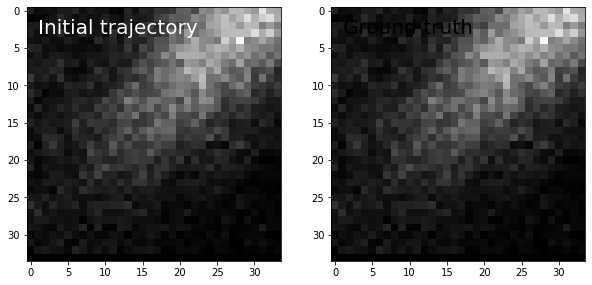

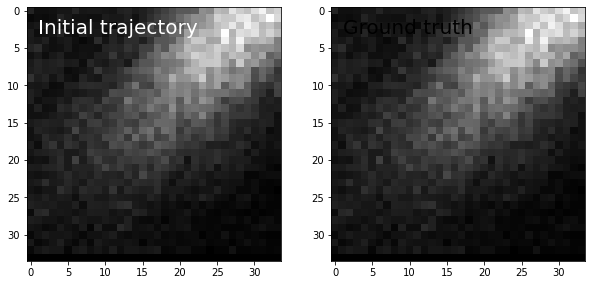

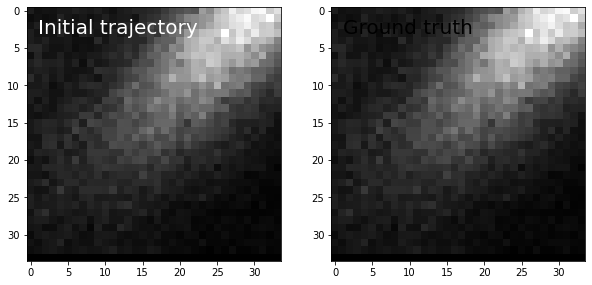

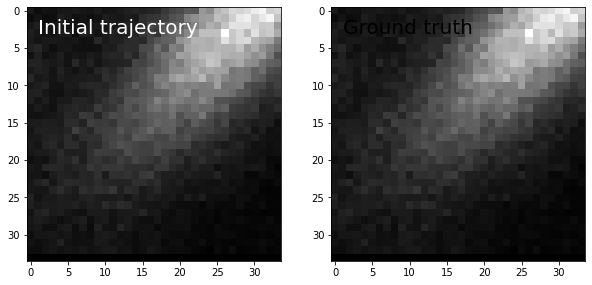

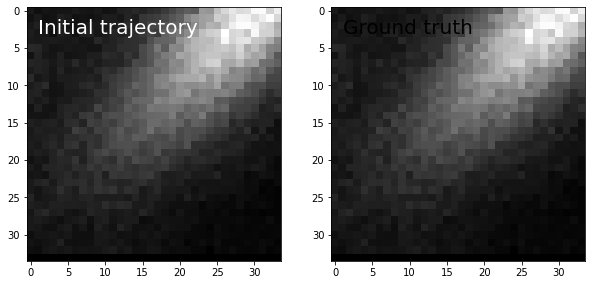

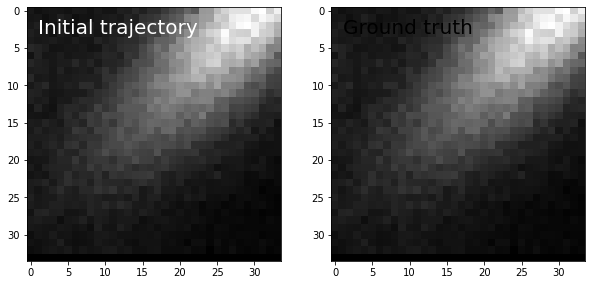

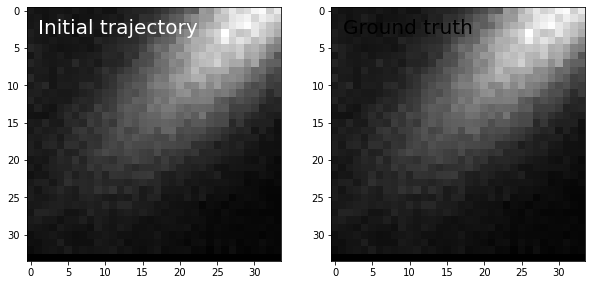

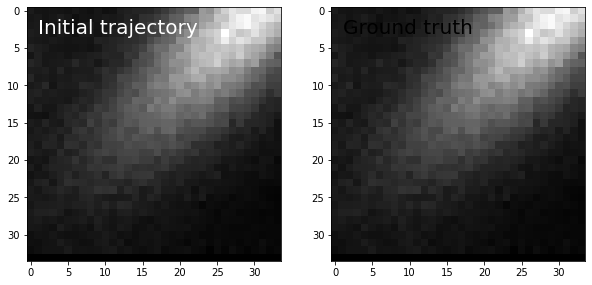

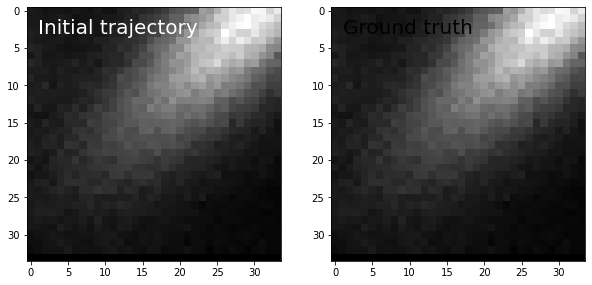

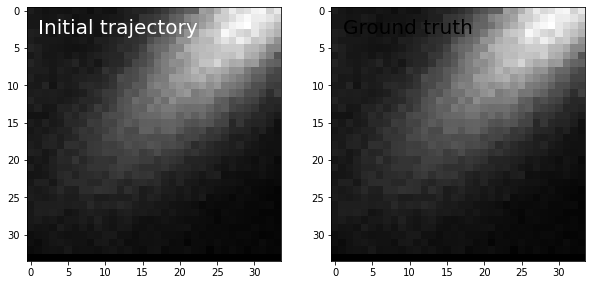

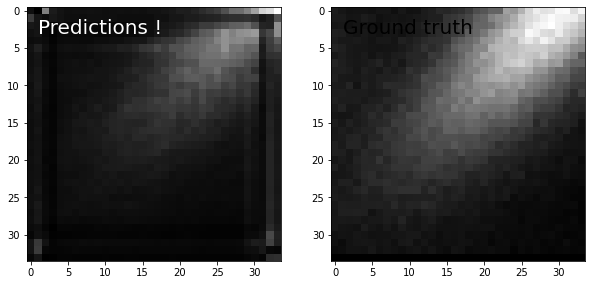

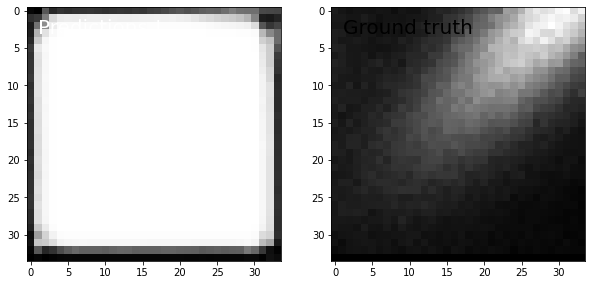

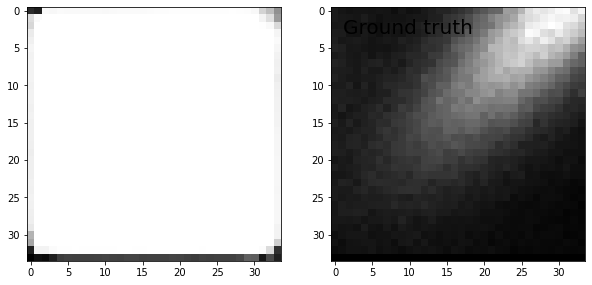

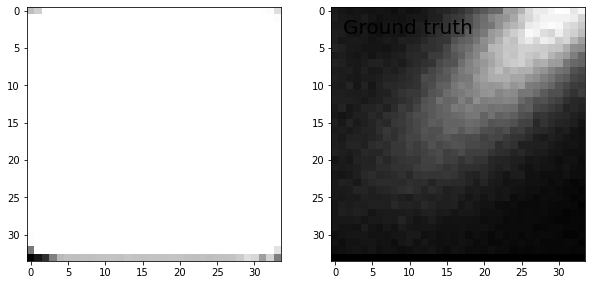

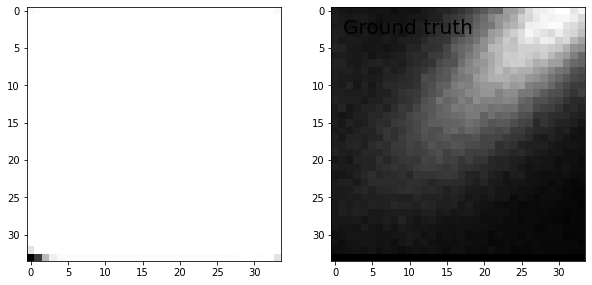

In [12]:
# Testing the network on one movie
# feed it with the first feed_first positions and then
# predict the new positions
which = 800
feed_first =  10
track = noisy_movies[which][:feed_first, ::, ::, ::]

for j in range(16):
    new_pos = Model.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)

# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))
    
    ax = fig.add_subplot(121)

    if i >= feed_first:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20, color='w')

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot,cmap='gray')
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot,cmap='gray')
    #plt.savefig('%i_animate.png' % (i + 1))